# Developing and Executing Error-Mitigated NISQ Algorithms Across Devices and Simulators

Cristina Cirstoiu &rarr; <cristina.cirstoiu@quantinuum.com>, 

Dan Mills &rarr; <daniel.mills@quantinuum.com>

Quantinuum

Notebooks and slides &rarr; https://github.com/CQCL/IEEE_Quantum_Week

## Part Three

We have covered:
1. Explore the tools available in TKET, providing a comprehensive, feature-focused tour of the platform.
2. Introduce noise, error mitigation and Qermit.

We will cover:
1. Introduction and getting started with Qermit.
2. Out of the box error-mitigation with Qermit; `MitRes` and `MitEx`.
3. Advanced use of Qermit to fine tune and combine error-mitigation schemes.
4. Developing new error-mitigation schemes.

# Error-Mitigation & NISQ Devices

Noise:
- Noisy Intermediate-Scale Quantum &rarr; low numbers of qubits and high error rates.
- Error correction, break encryption, Grover's search &rarr; ❌

Error-Mitigation:
- Trade reduced noise for increased circuit shots.
- Moderate to no increase in qubit requirements, unlike with error-correction.

## What is Qermit?

An open-source python package for the design and execution of digital error-mitigation.

By being implemented using TKET, Qermit is platform-agnostic, so may be used:
- With a wide range of quantum hardware.
- In conjunction with several common quantum software development kits.

A common interface to the following protocols, and several variations upon them, is presently available: 
- ZNE, CDR, and PEC; which mitigate for errors in expectation value calculations.
- Error-mitigation based on frame randomisation, and correction through characterisation of State Preparation And Measurement (SPAM) errors. 

Graph based architecture takes advantage of the modularity of error-mitigation schemes:
- Sub-processes: circuit execution, circuit modification, model fitting, etc. 
- Vertices may be amended to adapt the protocol. 
- Sub-graphs and graphs may be reused and combined. 

## Getting Started
<p><center> <code> pip install qermit </code> </center></p>
<p>Documentation and examples &rarr; <a href="www.qerm.it">www.qerm.it</a>.</p>
<p>Repository and manual &rarr; <a href="https://github.com/CQCL/qermit">https://github.com/CQCL/Qermit</a>.</p>

# Shot Count Experiment

There are two types of error mitigation methods in Qermit: 
- `MitRes` &rarr; modify the distribution of shots retrieved from a backend.
- `MitEx` &rarr; return a modified expectation value estimator of some observable.

MitRes and MitEx object may perform any modification of this form, or none.

- Now &rarr; experiments where the output is a collection of shots.
- Later &rarr; experiments where the output is an expectation value.

We will see experiments:
- Conducted in raw TKET, and the equivalent in Qermit.
- With and without errors.
- Where errors have been mitigated by a Qermit `MitRes`.

## Ideal Shot Count

Consider again the circuit to generate the bell pair:
\\[ \left| \psi \right\rangle = \frac{1}{\sqrt{2}} \left( \left| 00 \right\rangle + \left| 11 \right\rangle\right) \\]

In [1]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

circ = Circuit(2,2).H(0).CX(0,1).measure_all()
render_circuit_jupyter(circ)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_state_probs(state):
    state_dict = {'State':[i for i in range(len(result_state))], 'Probability':abs(state)**2}
    state_df = pd.DataFrame(state_dict)
    sns.catplot(x='State', y='Probability', kind='bar', data=state_df, aspect = 3, height=2)
    plt.show()
    
def plot_counts(counts):
    counts_record = [{"State":state, "Count":count} for state, count in counts.items()]
    count_df = pd.DataFrame().from_records(counts_record)
    sns.catplot(x='State', y='Count', kind='bar', data=count_df, aspect = 3, height=2)
    plt.show()

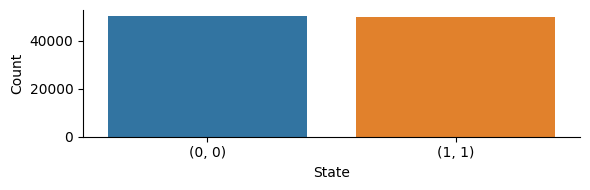

In [3]:
from pytket.extensions.qiskit import AerBackend

n_shots = 100000
ideal_backend = AerBackend()
result = ideal_backend.run_circuit(circ, n_shots=n_shots)
plot_counts(result.get_counts())

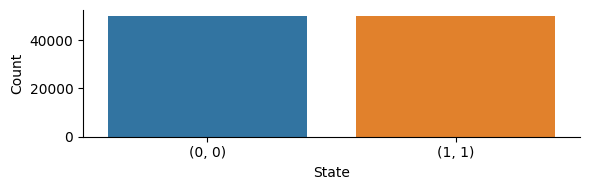

In [4]:
from qermit import MitRes, CircuitShots

ideal_mitres = MitRes(ideal_backend)

circ_shots_list = [CircuitShots(circ, n_shots)]

result_list = ideal_mitres.run(circ_shots_list)
result_counts = result_list[0].get_counts()
plot_counts(result_counts)

## MitRes TaskGraph

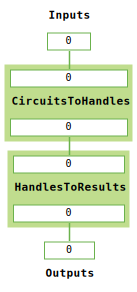

In [5]:
ideal_mitres.get_task_graph()

`MitRes` and `MitEx` objects are constructed as dataflow graphs, called a `TaskGraph`. 
- Each node of a `TaskGraph` is a `MitTask` object; itself a function that computes some step or sub-process of an error mitigation protocol. 
- Edges of the graph move data between `MitTask` objects. 
- When `run` is called, `MitTask`s are ordered and run sequentially.

## SPAM + Depolarising Noise Shot Count

In [6]:
import qiskit.providers.aer.noise as noise

def depolarizing_noise_model(n_qubits, prob_1, prob_2, prob_ro):

    noise_model = noise.NoiseModel()

    error_2 = noise.depolarizing_error(prob_2, 2)
    for edge in [[i,j] for i in range(n_qubits) for j in range(i)]:
        noise_model.add_quantum_error(error_2, ['cx'], [edge[0], edge[1]])
        noise_model.add_quantum_error(error_2, ['cx'], [edge[1], edge[0]])

    error_1 = noise.depolarizing_error(prob_1, 1)
    for node in range(n_qubits):
        noise_model.add_quantum_error(error_1, ['h', 'rx', 'rz', 'u'], [node])
        
    probabilities = [[1-prob_ro, prob_ro],[prob_ro, 1-prob_ro]]
    error_ro = noise.ReadoutError(probabilities)
    for i in range(n_qubits):
        noise_model.add_readout_error(error_ro, [i])
        
    return noise_model

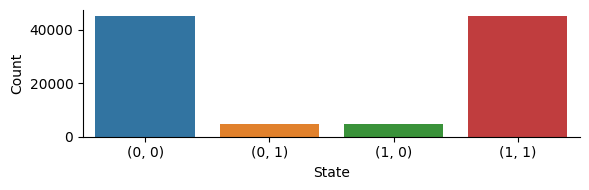

In [7]:
from qermit.taskgraph.mitex import MitEx, gen_compiled_MitRes
from pytket.extensions.qiskit import AerBackend

noisy_backend = AerBackend(
    depolarizing_noise_model(5, 0.001, 0.01, 0.05)
)
noisy_mitres = gen_compiled_MitRes(noisy_backend, optimisation_level=0)

noisy_result_list = noisy_mitres.run(circ_shots_list)
noisy_result_counts = noisy_result_list[0].get_counts()
plot_counts(noisy_result_counts)

## SPAM Error-Mitigation with Qermit

In [8]:
from qermit.spam import gen_UnCorrelated_SPAM_MitRes

spam_mr = gen_UnCorrelated_SPAM_MitRes(noisy_backend, n_shots)
spam_result_list = spam_mr.run(circ_shots_list)
spam_result_counts = spam_result_list[0].get_counts()

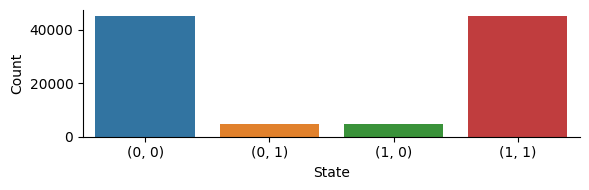

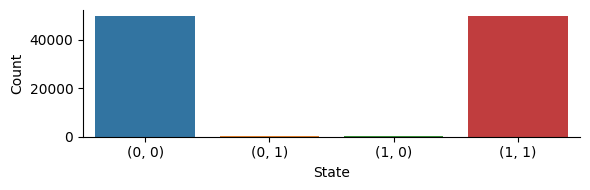

In [9]:
plot_counts(noisy_result_counts)
plot_counts(spam_result_counts)

## SPAM MitRes Task Graph

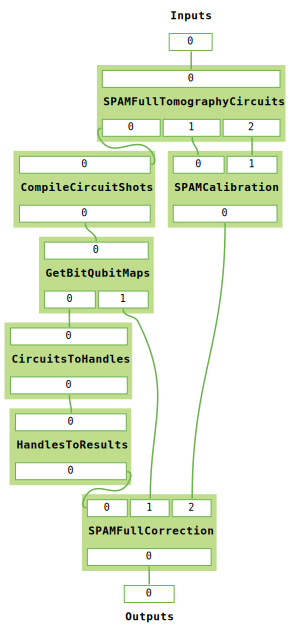

In [10]:
spam_mr.get_task_graph()

# Expectation Value Experiment

Experiments where the output is an expectation value.

We will see experiments:
- Conducted in raw TKET, and the equivalent in Qermit.
- With and without errors.
- Where errors have been mitigated by a Qermit `MitEx`.

## Ideal Expectation Value

In [11]:
import numpy as np
from scipy.stats import unitary_group
from pytket.circuit import Unitary2qBox

def random_circ(n_qubits: int, depth: int, seed:int = None) -> Circuit:
    
    np.random.seed(seed)

    c = Circuit(n_qubits)

    for _ in range(depth):

        qubits = np.random.permutation([i for i in range(n_qubits)])
        qubit_pairs = [[qubits[i], qubits[i + 1]] for i in range(0, n_qubits - 1, 2)]

        for pair in qubit_pairs:

            # Generate random 4x4 unitary matrix.
            SU4 = unitary_group.rvs(4)  # random unitary in SU4
            SU4 = SU4 / (np.linalg.det(SU4) ** 0.25)
            SU4 = np.matrix(SU4)

            # Add gate corresponding to unitary.
            c.add_unitary2qbox(Unitary2qBox(SU4), *pair)

    return c

In [12]:
n_qubits = 4
rand_circ = random_circ(n_qubits,n_qubits,seed=23126)
render_circuit_jupyter(rand_circ)

In [13]:
from pytket.pauli import Pauli, QubitPauliString
from pytket import Qubit

ideal_circuit = rand_circ.copy()
ideal_circuit = ideal_backend.get_compiled_circuit(ideal_circuit)

qps = QubitPauliString(
    [Qubit(i) for i in range(n_qubits)], 
    [Pauli.Z for i in range(n_qubits)]
)
ideal_result = ideal_backend.get_pauli_expectation_value(
    ideal_circuit, 
    qps
)
print(f"Ideal expectation: {ideal_result}")

Ideal expectation: 0.5549662007585151


In [14]:
from qermit import MitEx
from pytket.utils import QubitPauliOperator
from qermit import (
    AnsatzCircuit, 
    SymbolsDict, 
    ObservableExperiment, 
    ObservableTracker
)

ideal_mitex = MitEx(ideal_backend)

qpo = QubitPauliOperator({qps:1})
obs_exp = ObservableExperiment(
    AnsatzCircuit(rand_circ, n_shots, SymbolsDict()),
    ObservableTracker(qpo)
)
obs_exp_list = [obs_exp]

ideal_expectation = ideal_mitex.run(obs_exp_list)
print(f"Ideal expectation: {ideal_expectation[0]}")

Ideal expectation: {(Zq[0], Zq[1], Zq[2], Zq[3]): 0.556560000000000}


## MitEx Task Graph

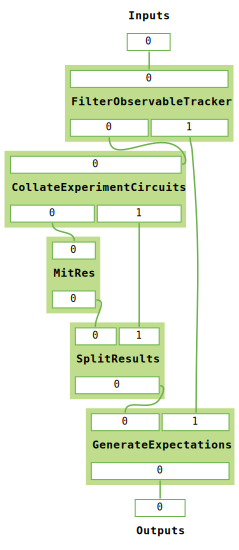

In [15]:
ideal_mitex.get_task_graph()

## Noisy Expectation Value

In [16]:
noisy_mitex = MitEx(noisy_backend)

noisy_expectation = noisy_mitex.run(obs_exp_list)
print(f"Noisy expectation: {noisy_expectation[0]}")

Noisy expectation: {(Zq[0], Zq[1], Zq[2], Zq[3]): 0.269620000000000}


## ZNE Error-Mitigation with Qermit

In [17]:
from qermit.zero_noise_extrapolation import (
    gen_ZNE_MitEx, Fit, Folding
)

zne_me = gen_ZNE_MitEx(backend=noisy_backend, 
                       noise_scaling_list=[9,7,5,3], 
                       fit_type=Fit.exponential, 
                       folding_type=Folding.circuit,
                       show_fit=True)

In [18]:
import seaborn as sns 
sns.set_style("whitegrid")

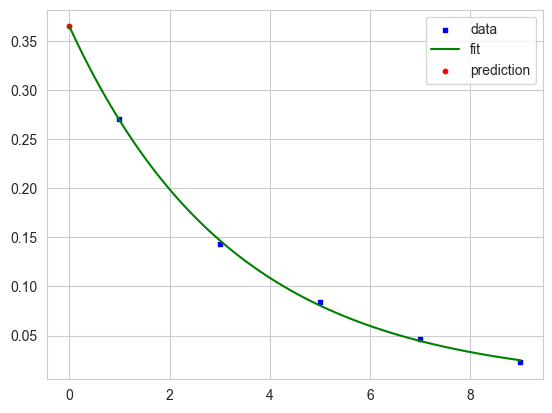

[{(Zq[0], Zq[1], Zq[2], Zq[3]): 0.365123873414805}]

In [19]:
zne_me.run(obs_exp_list)

## ZNE MitEx Task Graph

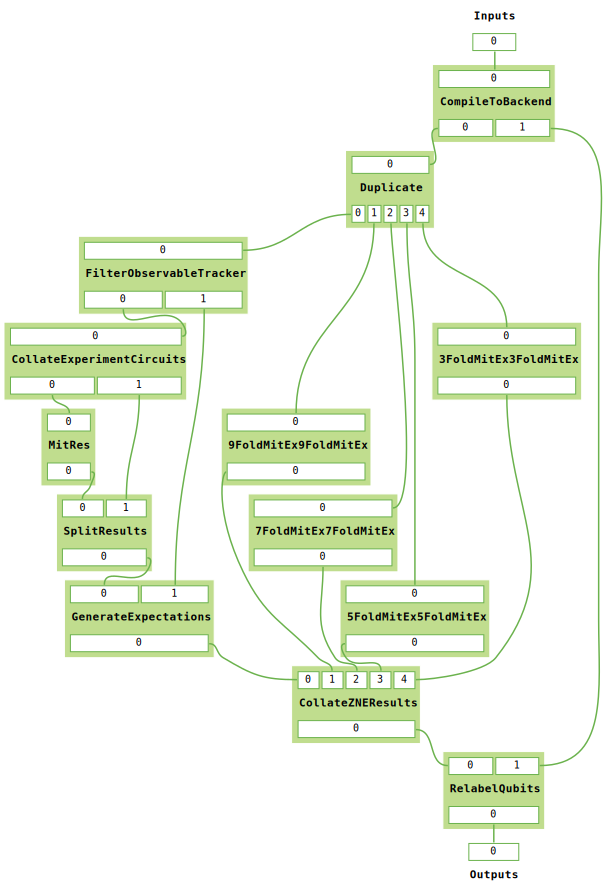

In [20]:
zne_me.get_task_graph()

## ZNE Options and Design

There are several alternatives when building a ZNE task graph. 

In [21]:
alt_zne_me = gen_ZNE_MitEx(backend=noisy_backend, 
                       noise_scaling_list=[5,4,3,2], 
                       fit_type=Fit.richardson, 
                       folding_type=Folding.gate,
                       show_fit=True)

Your favourites are available:
- Folding: `circuit`, `gate`, `odd_gate`
- Fit: `poly_exponential`, `exponential`, `polynomial`, `linear`, `richardson`

For many `MitEx` objects there are several options to personalise, without interacting directly with the `TaskGraph`.

# Advanced Qermit Use

We have seen:
- `MitRes` and `MitEx` objects.
- Use of predefined `MitRes` and `MitEx` objects, such as SPAM and ZNE.
- Personalised use of predefined objects.

We'll now look at some more advanced use cases:
- Combining error-mitigation protocols.
- Constructing original protocols.

## Combining Error-Mitigation Schemes

In [22]:
zne_spam_me = gen_ZNE_MitEx(backend=noisy_backend, 
                       noise_scaling_list=[9,7,5,3], 
                       fit_type=Fit.exponential, 
                       show_fit=True,
                       experiment_mitres=spam_mr)

## Combined ZNE SPAM Task Graph

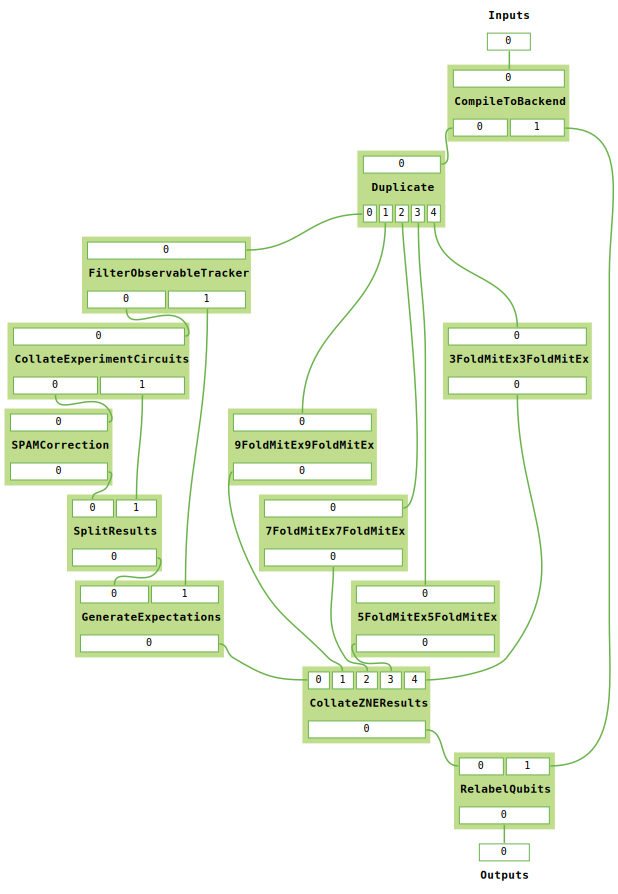

In [23]:
zne_spam_me.get_task_graph()

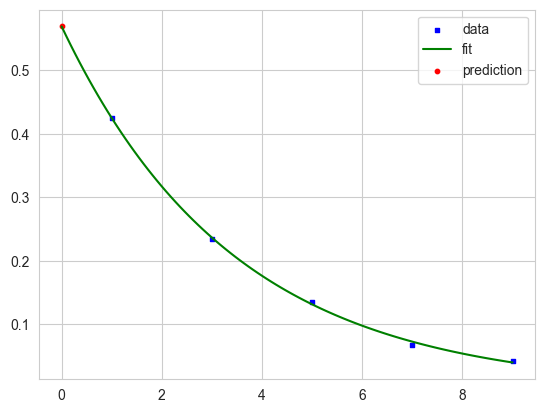

[{(Zq[0], Zq[1], Zq[2], Zq[3]): 0.569013723260058}]

In [24]:
zne_spam_me.run(obs_exp_list)

## Clifford Data Regression

In [25]:
from qermit.clifford_noise_characterisation import gen_CDR_MitEx

cdr_mitex = gen_CDR_MitEx(device_backend = noisy_backend,
                      simulator_backend = ideal_backend,
                      n_non_cliffords = 5,
                      n_pairs = 3,
                      total_state_circuits = 50)

## CDR Task Graph

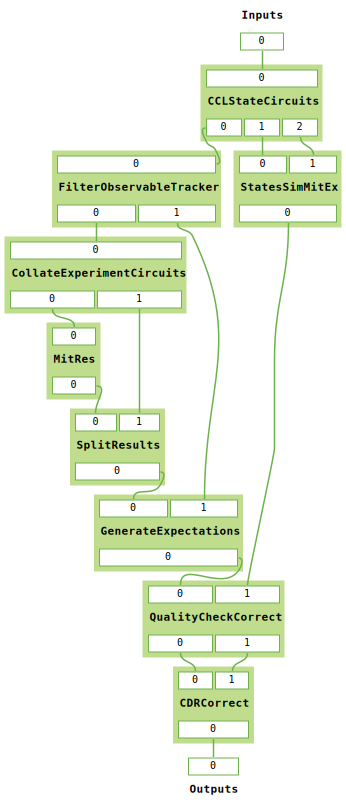

In [26]:
cdr_mitex.get_task_graph()

In [27]:
cdr_mitex.run(obs_exp_list)

/Users/danielmills/qermit/qermit/clifford_noise_characterisation/cdr_post.py:135: UserWarning: Training data regularly differs significantly from original circuit, fit and results may be poor.
  warnings.warn(


[{(Zq[0], Zq[1], Zq[2], Zq[3]): 0.690403102766169}]

## Developing Original Error-Mitigation Protocols

In [28]:
circ = Circuit(2)
circ.X(1).measure_all()
render_circuit_jupyter(circ)

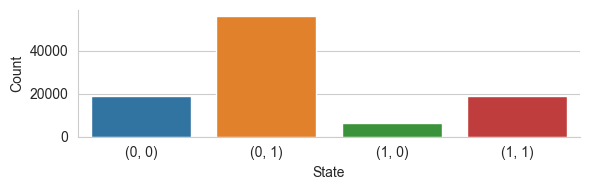

In [29]:
noisy_backend = AerBackend(depolarizing_noise_model(5, 0, 0, 0.25))
noisy_mitres = gen_compiled_MitRes(noisy_backend, optimisation_level=0)

circ_shots_list = [CircuitShots(circ, n_shots)]

result_list = noisy_mitres.run(circ_shots_list)
result_counts = result_list[0].get_counts()
plot_counts(result_counts)

## Find Zero MitRes TaskGraph

In [30]:
from pytket import OpType

def gen_find_zeros_task():
    
    def task(obj, circ_shots_list):
        zero_loc_list = []
        circ_size_list = []
        for circ_shot in circ_shots_list:
            not_zero_loc = []
            for command in circ_shot.Circuit.get_commands():
                if not command.op.type == OpType.Measure:
                    not_zero_loc.extend(command.qubits)
            zero_loc = [loc for loc in circ_shot.Circuit.qubits if loc not in not_zero_loc]
            zero_loc_list.append(zero_loc)
            circ_size_list.append(circ_shot.Circuit.n_qubits)
        return (circ_shots_list, zero_loc_list, circ_size_list, )
    
    return MitTask(
        _label="FindZeros", 
        _n_out_wires=3, 
        _n_in_wires=1, 
        _method=task
    )

In [31]:
from pytket.backends.backendresult import BackendResult

def gen_remove_ones_task():
    
    def task(obj, result_list, zero_loc_list, circ_size_list) -> Tuple[List[BackendResult]]:
        
        mitigated_result_list = []
        for result, zero_loc, circ_size in zip(result_list, zero_loc_list, circ_size_list):
            
            result_dict = result.to_dict()
            result_shots_array = result_dict['shots']['array']
            
            mitigated_result_shots_array = []
            for result_shots in result_shots_array:
                result_shot_binary = bin(result_shots[0])[2:].zfill(8)[:circ_size][::-1]
                delete_shot = False
                for zero in zero_loc:
                    if result_shot_binary[zero.index[0]] == "1": delete_shot = True
                if not delete_shot:
                    mitigated_result_shots_array.append(result_shots)
            
            result_dict['shots']['array'] = mitigated_result_shots_array
            mitigated_result_list.append(BackendResult.from_dict(result_dict))

        return (mitigated_result_list, )
    
    return MitTask(_label="RemoveOnes", _n_out_wires=1, _n_in_wires=3, _method=task)

In [32]:
from qermit.taskgraph.task_graph import TaskGraph
from typing import Tuple, List
from qermit.taskgraph.mittask import MitTask

taskgraph = TaskGraph().from_TaskGraph(noisy_mitres)

taskgraph.add_wire()
taskgraph.add_wire()

taskgraph.prepend(gen_find_zeros_task())
taskgraph.append(gen_remove_ones_task())

find_zero_mitres = MitRes(noisy_mitres).from_TaskGraph(taskgraph)

## Find Zero MitRes TaskGraph

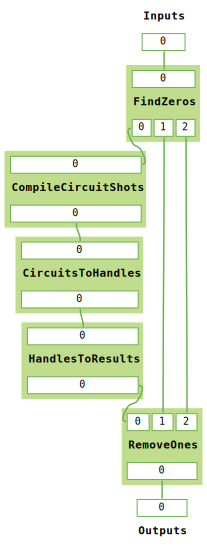

In [33]:
find_zero_mitres.get_task_graph()

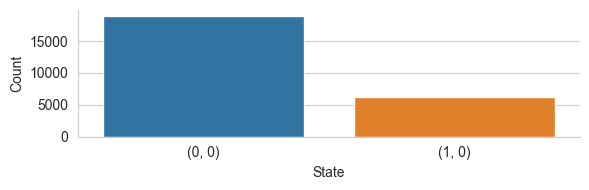

In [34]:
result_list = find_zero_mitres.run(circ_shots_list)
result_counts = result_list[0].get_counts()
plot_counts(result_counts)

## Spectral Analysis MitEx TaskGraph

In [35]:
from qermit.taskgraph.mittask import MitTask
import numpy as np

def gen_param_grid_gen_task(n_vals):
    
    def task(obj, obs_exp_list):
        
        # A parameter grid is generated for each ObservableExperiment in obs_exp_list
        param_grid_list = []
        for obs_exp in obs_exp_list:
                        
            # List of symbols used in circuit
            sym_list = obs_exp.AnsatzCircuit.SymbolsDict.symbols_list
            
            # Lists of values taken by parameters, in half rotations
            param_val_list = [np.linspace(0, 2, n_vals, endpoint=False) for _ in sym_list]
            
            # Grids corresponding to paramert values
            param_grid = np.meshgrid(*param_val_list)
            param_grid_list.append(param_grid)
                    
        return (obs_exp_list, param_grid_list,)
    
    return MitTask(_label="ParamGridGen", _n_out_wires=2, _n_in_wires=1, _method=task)

In [36]:
import copy
from itertools import product

def empty_array(n_vals, dim):
    
    empty = None
    for _ in range(dim):
        empty = [empty] * n_vals
        
    return np.array(empty)

def gen_obs_exp_grid_gen_task(n_vals):
    
    def task(obj, obs_exp_list, param_grid_list):
        
        # A grid of ObservableExperiment is generated for each ObservableExperiment in obs_exp_list
        obs_exp_grid_list = []
        for obs_exp, param_grid in zip(obs_exp_list, param_grid_list):
                      
            # List of symbols in circuit
            sym_list = list(obs_exp.AnsatzCircuit.SymbolsDict.symbols_list)
            # TODO: Remove n_vals as an input here. It should be recoverable from param_grid
            obs_exp_grid = empty_array(n_vals, len(sym_list))
            shots = obs_exp.AnsatzCircuit.Shots
                        
            # Generate an ObservableExperiment for every parameter value in the grid
            for grid_point in product([i for i in range(n_vals)],repeat=len(sym_list)):
                                                
                sym_map = {sym:param[grid_point] for param, sym in zip(param_grid, sym_list)}  
                sym_dict = SymbolsDict().symbols_from_dict(sym_map)
                
                circ = obs_exp.AnsatzCircuit.Circuit.copy()
                
                anz_circ = AnsatzCircuit(circ, shots, sym_dict)
                obs = copy.deepcopy(obs_exp.ObservableTracker)
                
                obs_exp_grid[grid_point] = ObservableExperiment(anz_circ, obs)
                                
            obs_exp_grid_list.append(obs_exp_grid)
        
        return (obs_exp_grid_list, obs_exp_list, param_grid_list, )
    
    return MitTask(_label="ObsExpGridGen", _n_out_wires=3, _n_in_wires=2, _method=task)


In [37]:
from pytket.utils import QubitPauliOperator

def gen_flatten_task(n_vals):
    
    def task(obj, obs_exp_grid_list, obs_exp_list):
        
        # ObservableExperiments, currently stored in a grid, are flattned to a single list.
        # TODO: Is there a way of going this with the array flatten function
        flattened_obs_exp_list = []
        # Store strcuture of flattned grid as list of dictionaries.
        struct_list = []
                
        for i, (obs_exp, obs_exp_grid) in enumerate(zip(obs_exp_list, obs_exp_grid_list)):
            
            sym_list = list(obs_exp.AnsatzCircuit.SymbolsDict.symbols_list)
                        
            # Iterate through each grid point, and add ObservableExperiment to list
            for grid_point in product([i for i in range(n_vals)],repeat=len(sym_list)):
                flattened_obs_exp_list.append(obs_exp_grid[grid_point])
                struct_list.append({"experiment":i, "grid point":grid_point})
                                            
        return (flattened_obs_exp_list, struct_list, obs_exp_list, )
    
    return MitTask(_label="Flatten", _n_out_wires=3, _n_in_wires=2, _method=task)

def gen_unflatten_task(n_vals):
    
    def task(obj, result_list, struct_list, obs_exp_list) -> Tuple[List[QubitPauliOperator]]:
        
        result_grid_list = []
        
        # For each ObservableExperiment, create appropriatly sizes result grid
        for obs_exp in obs_exp_list:
            sym_list = list(obs_exp.AnsatzCircuit.SymbolsDict.symbols_list)
            result_grid_list.append(empty_array(n_vals, len(sym_list)))
        
        # For all results, add to the appropriate grid and grid point
        for result, struct in zip(result_list, struct_list):
            result_grid_list[struct["experiment"]][struct["grid point"]] = result
                
        return (result_grid_list, obs_exp_list, )
    
    return MitTask(_label="Unflatten", _n_out_wires=2, _n_in_wires=3, _method=task)

In [38]:
import matplotlib.pyplot as plt

def my_plot(z, *axis):
    
    if len(axis)==2:
        plot_3d(*axis, z)
    elif len(axis)==1:
        plot_2d(*axis, z)

def plot_3d(x,y,z):
    
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(x,y, np.real(z))
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(x,y, np.imag(z))
    
    plt.show()
    
def plot_2d(x,y):
    
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(x, np.real(y))
    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(x, np.imag(y))
    
    plt.show()

In [39]:
from numpy.fft import fftn, fftfreq, ifftn

def gen_fft_task(n_vals):
    
    def task(obj, result_grid_list, obs_exp_list, param_grid_list):
        
        fft_result_grid_list = []
        
        for qpo_result_grid, obs_exp, param_grid in zip(result_grid_list, obs_exp_list, param_grid_list):
                        
            sym_list = list(obs_exp.AnsatzCircuit.SymbolsDict.symbols_list)
            
            # for each point in qpo_result_grid, extract expectation value
            result_grid = empty_array(n_vals, len(sym_list))                  
            for grid_point in product([i for i in range(n_vals)],repeat=len(sym_list)):
                qpo_result_dict = qpo_result_grid[grid_point]._dict
                result = qpo_result_dict[list(qpo_result_dict.keys())[0]]
                result_grid[grid_point] = result
                                      
            # Perform FFT on grid of results.
            fft_result_grid = np.fft.fftn(result_grid) 
            fft_result_grid_list.append(fft_result_grid)
                        
            my_plot(result_grid, *param_grid)
            my_plot(fft_result_grid, *param_grid)
            
        return (fft_result_grid_list, param_grid_list, obs_exp_list, )
    
    return MitTask(_label="FFT", _n_out_wires=3, _n_in_wires=3, _method=task)

In [40]:
def gen_mitigation_task(tol):
    
    # TODO: Note that obs_exp_list is not used here
    def task(obj, fft_result_val_grid_list, param_grid_list, obs_exp_list):
        
        # Iterate through results grids and set values close to 0 to 0
        mitigated_fft_result_val_grid_list = []
        for fft_result_val_grid, param_grid in zip(fft_result_val_grid_list, param_grid_list):
            
            fft_result_val_grid[np.abs(fft_result_val_grid) < tol] = 0.0
            mitigated_fft_result_val_grid_list.append(fft_result_val_grid)
            
            my_plot(fft_result_val_grid, *param_grid)
        
        return (mitigated_fft_result_val_grid_list, param_grid_list, obs_exp_list)
    
    return MitTask(_label="Mitigation", _n_out_wires=3, _n_in_wires=3, _method=task)

In [41]:
def gen_inv_fft_task():
    
    # TODO: Note that obs_exp_list is not used here
    def task(obj, mitigated_fft_result_val_grid_list, param_grid_list, obs_exp_list):
        
        # Iterate through results and invert FFT
        mitigated_result_val_grid_list = []
        for mitigated_fft_result_val_grid, param_grid in zip(mitigated_fft_result_val_grid_list, param_grid_list):
                        
            mitigated_result_val_grid = np.fft.ifftn(mitigated_fft_result_val_grid)
            mitigated_result_val_grid_list.append(mitigated_result_val_grid)
                
            my_plot(mitigated_result_val_grid, *param_grid)
            
        return (mitigated_result_val_grid_list, )
    
    return MitTask(_label="InvFFT", _n_out_wires=1, _n_in_wires=3, _method=task)

In [42]:
def gen_result_extraction_task():
    
    def task(obj, results) -> Tuple[List[QubitPauliOperator]]:
        return (results, )
    
    return MitTask(_label="ResultExtraction", _n_out_wires=1, _n_in_wires=1, _method=task)

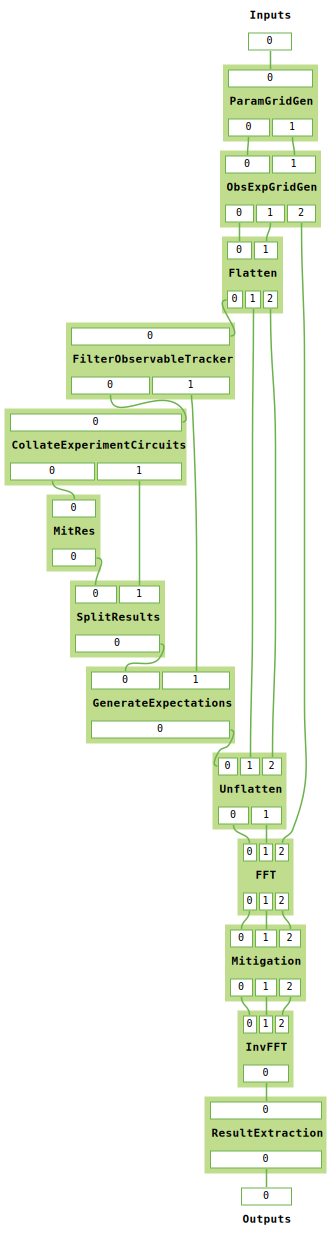

In [43]:
from qermit.taskgraph.task_graph import TaskGraph
from typing import Tuple, List
from qermit.taskgraph.mittask import (
    MitTask,
    CircuitShots,
    Wire,
)

n_vals=8

experiment_taskgraph = TaskGraph().from_TaskGraph(noisy_mitex)
experiment_taskgraph.add_wire()
experiment_taskgraph.add_wire()
experiment_taskgraph.prepend(gen_flatten_task(n_vals=n_vals))
experiment_taskgraph.append(gen_unflatten_task(n_vals=n_vals))

experiment_taskgraph.add_wire()
experiment_taskgraph.prepend(gen_obs_exp_grid_gen_task(n_vals=n_vals))

experiment_taskgraph.prepend(gen_param_grid_gen_task(n_vals=n_vals))

experiment_taskgraph.append(gen_fft_task(n_vals=n_vals))

experiment_taskgraph.append(gen_mitigation_task(tol=5))

experiment_taskgraph.append(gen_inv_fft_task())
experiment_taskgraph.append(gen_result_extraction_task())

experiment_taskgraph = MitEx(noisy_mitex).from_TaskGraph(experiment_taskgraph)
experiment_taskgraph.get_task_graph()

In [44]:
from sympy import Symbol

a = Symbol("alpha")
b = Symbol("beta")

circ = Circuit(2)
circ.H(0).H(1).Rz(a, 0).Rz(b, 1).H(0).H(1)
render_circuit_jupyter(circ)

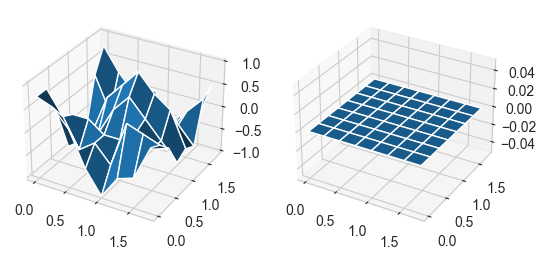

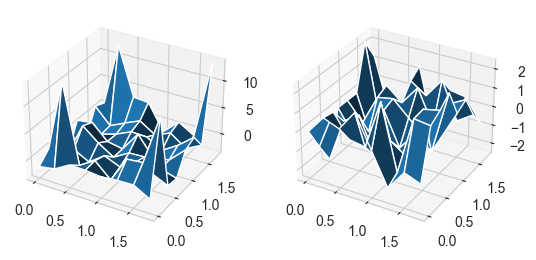

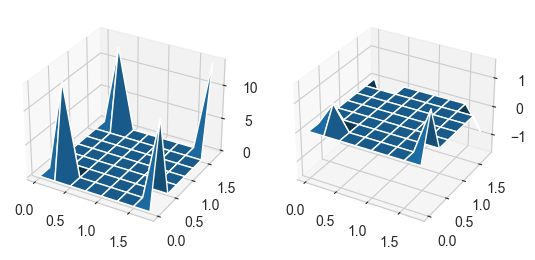

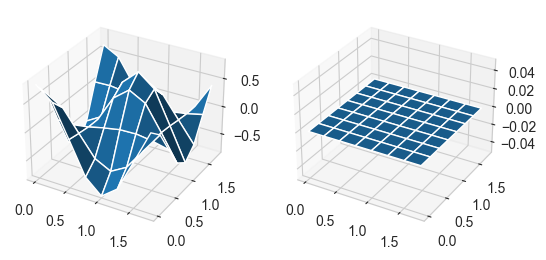

[array([[ 0.80818142+0.j,  0.58804338+0.j,  0.0234375 +0.j,
         -0.55489775+0.j, -0.80818142+0.j, -0.58804338+0.j,
         -0.0234375 +0.j,  0.55489775+0.j],
        [ 0.51812348+0.j,  0.3571344 +0.j, -0.01305916+0.j,
         -0.37560285+0.j, -0.51812348+0.j, -0.3571344 +0.j,
          0.01305916+0.j,  0.37560285+0.j],
        [-0.07544417+0.j, -0.08297907+0.j, -0.04190595+0.j,
          0.02371511+0.j,  0.07544417+0.j,  0.08297907+0.j,
          0.04190595+0.j, -0.02371511+0.j],
        [-0.62481765+0.j, -0.47448452+0.j, -0.04620479+0.j,
          0.40914108+0.j,  0.62481765+0.j,  0.47448452+0.j,
          0.04620479+0.j, -0.40914108+0.j],
        [-0.80818142+0.j, -0.58804338+0.j, -0.0234375 +0.j,
          0.55489775+0.j,  0.80818142+0.j,  0.58804338+0.j,
          0.0234375 +0.j, -0.55489775+0.j],
        [-0.51812348+0.j, -0.3571344 +0.j,  0.01305916+0.j,
          0.37560285+0.j,  0.51812348+0.j,  0.3571344 +0.j,
         -0.01305916+0.j, -0.37560285+0.j],
        [ 0.0754

In [45]:
sym_dict = SymbolsDict().symbols_from_dict({a:0.3, b:1.25})
qubit_pauli_string = QubitPauliString(
    [Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]
)
ansatz_circuit = AnsatzCircuit(circ, 16, sym_dict)
exp = ObservableExperiment(
        ansatz_circuit,
        ObservableTracker(QubitPauliOperator({qubit_pauli_string: 1.0})),
    )

experiment_taskgraph.run([exp])

# Conclusion

In the last hour we have:
1. Introduction and getting started with Qermit.
2. Out of the box error-mitigation with Qermit; `MitRes` and `MitEx`.
3. Advanced use of Qermit to fine tune and combine error-mitigation schemes.
4. Developing new error-mitigation schemes.

In the last three hours we have:
1. Explore the tools available in TKET, providing a comprehensive, feature-focused tour of the platform.
2. Introduce noise and error mitigation.
2. Exemplify out of the box and advanced usage of Qermit for the composition and design of error-mitigation protocols.

<center> <h1> Questions </h1> </center>